In [1]:
%load_ext autoreload
%autoreload 2
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
from config.settings import *

In [2]:
from functools import partial
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms.v2.functional as F
import numpy as np
from ray import tune
from ray.air import Checkpoint, session
from ray.tune.schedulers import ASHAScheduler
from src.models.unet import UNet, find_next_valid_size
from src.models.loss import DiceBCELoss, DiceLoss, FocalLoss, IoULoss
from src.data.loaders import load_data_mitosemseg

/home/kristian/mambaforge/envs/mitotem/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/kristian/mambaforge/envs/mitotem/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please

In [ ]:
def train_unet(config, num_workers=0, max_epochs=100):
    net = UNet(encoder_depth=config['encoder_depth'],
               dropout=config['dropout'])

    device = torch.device('cpu')
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    common = {k: config[k] for k in ('lr','weight_decay')}
    common['params'] = net.parameters()
    optims = {
        'sgd': optim.SGD(**common, momentum=config['momentum']),
        'adam': optim.Adam(**common),
        'adam': optim.AdamW(**common),
    }

    criterion = nn.CrossEntropyLoss()
    optimizer = optims[config['optimizer']]

    checkpoint = session.get_checkpoint()
    if checkpoint:
        checkpoint_state = checkpoint.to_dict()
        start_epoch = checkpoint_state["epoch"]
        net.load_state_dict(checkpoint_state["net_state_dict"])
        optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 1

    data_dir = os.getenv('LOCAL_SCRATCH') + '/dataset'
    input_size, output_size = find_next_valid_size(1000, 3, config['encoder_depth'])
    trainset, valset = load_data_mitosemseg(data_dir, input_size, split=0.85)

    train_iter = DataLoader(trainset, config['batch_size'], shuffle=True, num_workers=num_workers)
    val_iter = DataLoader(valset, config['batch_size'], shuffle=False, num_workers=num_workers)

    for epoch in range(start_epoch, max_epochs+1):
        running_loss = 0.0
        epoch_steps = 0
        for i, (inputs, targets) in enumerate(train_iter,1):
            targets = F.center_crop(targets, output_size)
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            epoch_steps +=1
            if i % 2000 == 0:
                print(f"[{epoch}, {i:>5}] loss: {running_loss/epoch_steps:.3f}")
                running_loss = 0.0

        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, (inputs, targets) in enumerate(val_iter, 1):
            with torch.no_grad():
                targets = F.center_crop(targets, output_size)
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

                loss = criterion(outputs, targets)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        checkpoint_data = {
            "epoch": epoch,
            "net_state_dict": net.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }
        checkpoint = Checkpoint.from_dict(checkpoint_data)

        session.report(
            {"loss": val_loss/val_steps, "accuracy": correct/total},
            checkpoint=checkpoint,
        )
    print("Finished training")

In [ ]:
def main(num_samples=10, max_num_epochs=10, num_workers=0, gpus_per_trial=2):
    config = {
        "batch_size": tune.grid_search([1,2,4]),
        "optimizer": tune.grid_search(['sgd','adam','adamw']),
        "lr": tune.loguniform(1e-4, 1e-1),
        "dropout": tune.uniform(0.0,0.5),
        "momentum": tune.sample_from(
            lambda spec: 
            np.random.uniform(0.5, 0.99) if spec.config.optimizer == 'sgd' else None),
        "weight_decay": tune.grid_search([1e-3, 1e-4, 1e-5, 0]),
        "encoder_depth": tune.grid_search([3,4,5]),
    }

    scheduler = ASHAScheduler(
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2,
    )

    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_unet),
            resources={"cpu": num_workers, "gpu": gpus_per_trial},
        ),
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            scheduler=scheduler,
            num_samples=num_samples
        ),
        param_space=config,
    )
    
    result = tuner.fit()
    
    best_result = result.get_best_result("loss", "min", "last")
    print(f"Best trial config: {best_result.config}")
    print(f"Best trial final validation loss: {best_result.last_result['loss']}")
    print(f"Best trial final validation accuracy: {best_result.last_result['accuracy']}")


if __name__ == "__main__":
    main(num_samples=10, max_num_epochs=10, gpus_per_trial=0)

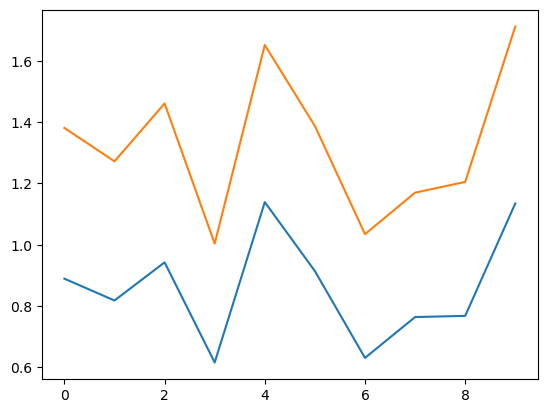

In [20]:
import matplotlib.pyplot as plt
ce = nn.CrossEntropyLoss()
iou = DiceBCELoss()

n = 10
results = np.zeros((n,2))
for i in range(n):
    x = torch.randn((1,2,5,5))
    target = torch.randint(0,2,(1,5,5))
    results[i,:] = [ce(x,target),iou(x,target)]

plt.plot(list(range(n)), results)